In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [11]:
data = pd.read_csv('eco_rating.csv')
data.head()

,user_id,item_id,ratings
0,1,28,2
1,1,86,4
2,1,94,4
3,1,146,3
4,2,17,2


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 849 entries, 0 to 848
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   user_id  849 non-null    int64
 1   item_id  849 non-null    int64
 2   ratings  849 non-null    int64
dtypes: int64(3)
memory usage: 20.0 KB


In [15]:
# Mengetahui total unique dari kolom user_id & item_id
len(data.user_id.unique())
len(data.item_id.unique())

182

In [16]:
# Mengetahui keberadaan data yang hilang pada dataframe

data.isnull().sum()

user_id    0
item_id    0
ratings    0
dtype: int64

In [17]:
# Menghapus data duplikat di kolom item_id

data_prep = data.drop_duplicates('item_id')

In [18]:
data_prep.describe()

,user_id,item_id,ratings
count,182.000000,182.000000,182.000000
mean,33.912088,92.500000,3.521978
std,29.649201,52.683014,0.896316
min,1.000000,2.000000,2.000000
25%,10.250000,47.250000,3.000000
50%,25.000000,92.500000,4.000000
75%,52.500000,137.750000,4.000000
max,154.000000,183.000000,5.000000


In [19]:
# Membuat list dari nilai unique pada user_id & item_id

user_ids = data.user_id.unique().tolist()
item_ids = data.item_id.unique().tolist()

In [22]:
# Konversi data user_id & item_id ke label encoder

user_to_user_encoded = {x:i for i, x in enumerate(user_ids)}
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}

place_to_place_encoded = {x: i for i, x in enumerate(item_ids)}
place_encoded_to_place = {x: i for x, i in enumerate(item_ids)}

In [23]:
data['user'] = data.user_id.map(user_to_user_encoded)
data['item'] = data.item_id.map(place_to_place_encoded)

data.head()

,user_id,item_id,ratings,user,item
0,1,28,2,0,0
1,1,86,4,0,1
2,1,94,4,0,2
3,1,146,3,0,3
4,2,17,2,1,4


In [48]:
data['ratings'] = data['ratings'].values.astype(np.float32)
data

,user_id,item_id,ratings,user,item
0,1,28,2.0,0,0
1,1,86,4.0,0,1
2,1,94,4.0,0,2
3,1,146,3.0,0,3
4,2,17,2.0,1,4
...,...,...,...,...,...
844,156,144,4.0,155,88
845,156,15,5.0,155,46
846,156,29,4.0,155,77
847,156,52,4.0,155,155


In [52]:
df = data.sample(frac=1,random_state=42)
df.head()

,user_id,item_id,ratings,user,item
512,93,39,4.0,92,129
357,66,79,3.0,65,151
110,22,10,4.0,21,86
684,125,76,3.0,124,136
39,7,104,4.0,6,23


In [60]:
x = df[['user','item']].values

y = df['ratings'].apply(lambda x:(x-min(df.ratings))/(max(df.ratings-min(df.ratings)))).values

train_indices = int(0.8 * df.shape[0])

x_train,x_val,y_train,y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(x,y)

[[ 92 129]
 [ 65 151]
 [ 21  86]
 ...
 [ 49  45]
 [ 78 108]
 [ 19  80]] [0.66666667 0.33333333 0.66666667 0.33333333 0.66666667 0.33333333
 0.66666667 0.33333333 0.         0.66666667 0.33333333 0.33333333
 0.         0.66666667 0.33333333 0.66666667 0.         0.33333333
 0.33333333 0.66666667 1.         0.33333333 0.66666667 0.33333333
 0.33333333 0.66666667 0.33333333 1.         0.         0.33333333
 0.         0.33333333 0.33333333 0.33333333 1.         0.66666667
 0.66666667 0.33333333 0.33333333 0.         0.66666667 0.66666667
 0.33333333 0.33333333 0.66666667 0.         0.         0.33333333
 0.33333333 0.         0.66666667 0.         0.66666667 0.66666667
 0.66666667 0.33333333 0.66666667 0.33333333 0.66666667 0.66666667
 0.33333333 0.66666667 0.33333333 0.66666667 0.66666667 0.33333333
 1.         1.         0.33333333 1.         0.         0.66666667
 0.66666667 0.         0.66666667 0.         0.66666667 0.33333333
 0.66666667 0.33333333 1.         0.66666667 0.33333333 0

In [61]:
class RecommenderNet(tf.keras.Model):

  # Insialisasi fungsi
  def __init__(self, num_users, num_place, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_place = num_place
    self.embedding_size = embedding_size
    self.user_embedding = tf.keras.layers.Embedding(
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = tf.keras.regularizers.l2(1e-6)
    )
    self.user_bias = tf.keras.layers.Embedding(num_users, 1)
    self.place_embedding = tf.keras.layers.Embedding(
        num_place,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = tf.keras.regularizers.l2(1e-6)
    )
    self.place_bias = tf.keras.layers.Embedding(num_place, 1)

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # memanggil layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # memanggil layer embedding 2
    place_vector = self.place_embedding(inputs[:, 1]) # memanggil layer embedding 3
    place_bias = self.place_bias(inputs[:, 1]) # memanggil layer embedding 4

    dot_user_place = tf.tensordot(user_vector, place_vector, 2)

    x = dot_user_place + user_bias + place_bias

    return tf.nn.sigmoid(x) # activation sigmoid

In [62]:
model = RecommenderNet(len(user_to_user_encoded), len(place_to_place_encoded), 100)

# model compile
model.compile(
    loss = 'mean_squared_error',
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)

In [63]:
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 16,
    epochs = 100,
    validation_data = (x_val, y_val),
)

Epoch 1/100
43/43 [==============================] - 1s 8ms/step - loss: 0.1105 - mean_absolute_error: 0.2747 - val_loss: 0.1276 - val_mean_absolute_error: 0.2918
Epoch 2/100
43/43 [==============================] - 0s 3ms/step - loss: 0.1058 - mean_absolute_error: 0.2696 - val_loss: 0.1279 - val_mean_absolute_error: 0.2920
Epoch 3/100
43/43 [==============================] - 0s 3ms/step - loss: 0.1062 - mean_absolute_error: 0.2738 - val_loss: 0.1304 - val_mean_absolute_error: 0.2947
Epoch 4/100
43/43 [==============================] - 0s 3ms/step - loss: 0.1086 - mean_absolute_error: 0.2705 - val_loss: 0.1309 - val_mean_absolute_error: 0.2956
Epoch 5/100
43/43 [==============================] - 0s 3ms/step - loss: 0.0988 - mean_absolute_error: 0.2650 - val_loss: 0.1304 - val_mean_absolute_error: 0.2949
Epoch 6/100
43/43 [==============================] - 0s 3ms/step - loss: 0.1066 - mean_absolute_error: 0.2675 - val_loss: 0.1300 - val_mean_absolute_error: 0.2942
Epoch 7/100
43/43 [===

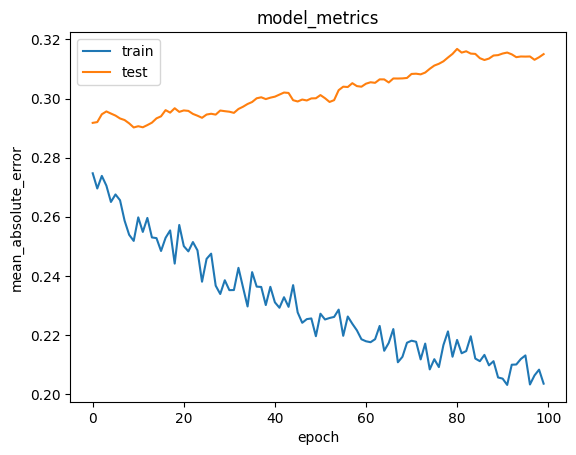

In [70]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model_metrics')
plt.ylabel('mean_absolute_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

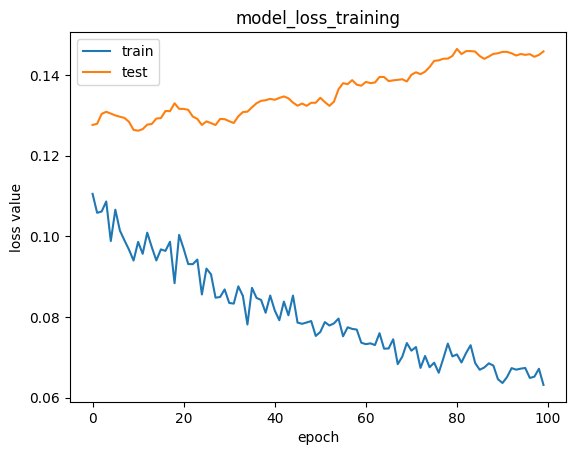

In [99]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss_training')
plt.ylabel('loss value')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [102]:
result_mae = model.evaluate(x_val, y_val)
print(f'MAE: {result_mae[1]}')

6/6 [==============================] - 0s 5ms/step - loss: 0.1547 - mean_absolute_error: 0.3229
MAE: 0.32288658618927


6/6 [==============================] - 0s 4ms/step


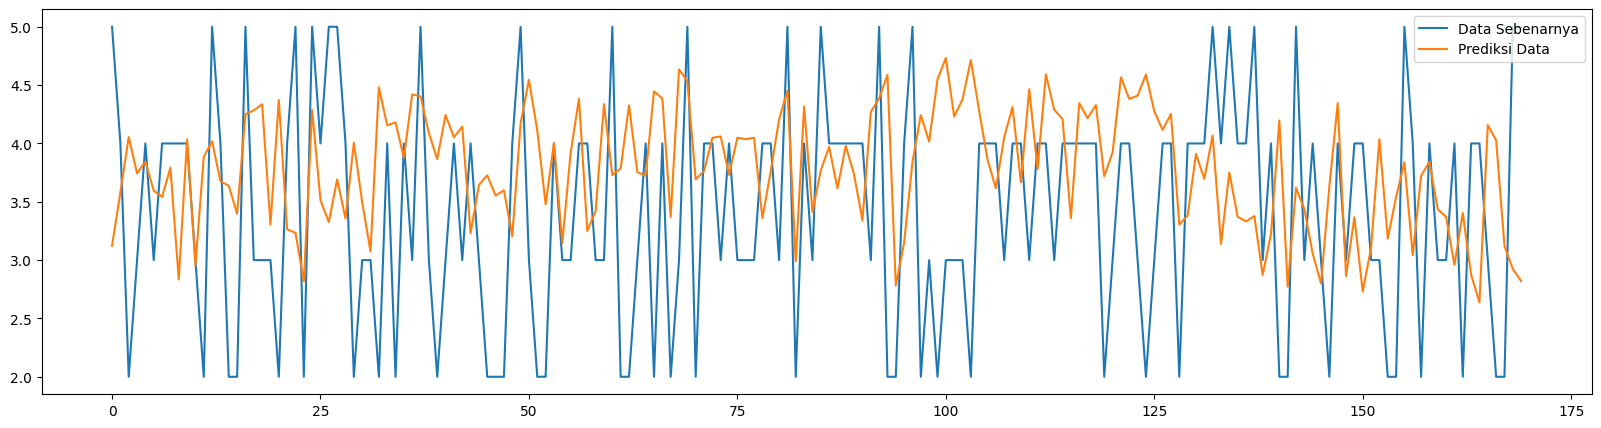

In [98]:
prediction_test = model.predict(x_val)
data_format_original = [(x * (max(df.ratings) - min(df.ratings)) + min(df.ratings)) for x in prediction_test]
x1 = np.arange(len(x_val))
plt.figure(figsize=(20,5))

plt.plot(x1, df.ratings[train_indices:], label='Data Sebenarnya')
plt.plot(x1, data_format_original, label='Prediksi Data')
plt.legend()

Dibawah digunakan model GMF + MLP

In [113]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsoluteError

In [115]:
train_data, val_data = train_test_split(df, test_size=0.2, random_state=42)

# Jumlah pengguna dan item
num_users = df['user'].nunique()
num_items = df['item'].nunique()
#y_input = df['ratings'].apply(lambda x:(x-min(df.ratings))/(max(df.ratings-min(df.ratings)))).values

# Menentukan ukuran embedding
embedding_size = 32

# Input layer
user_input = Input(shape=(1,), name='user_input')
item_input = Input(shape=(1,), name='item_input')

# Embedding layer for GCF
user_embedding = Embedding(input_dim=num_users, output_dim=embedding_size, input_length=1)(user_input)
item_embedding = Embedding(input_dim=num_items, output_dim=embedding_size, input_length=1)(item_input)

# Flatten embeddings
user_flat = Flatten()(user_embedding)
item_flat = Flatten()(item_embedding)

# Concatenate embeddings for GCF
concatenated_gcf = Concatenate()([user_flat, item_flat])

# Multi-Layer Perceptron (MLP)
mlp_input = Concatenate()([user_embedding, item_embedding])
mlp_flatten = Flatten()(mlp_input)
mlp_fc1 = Dense(64, activation='relu')(mlp_flatten)
mlp_output = Dense(1)(mlp_fc1)

# Combine GCF and MLP outputs
combined = Concatenate()([concatenated_gcf, mlp_output])

# Fully connected layers for final prediction
final_fc1 = Dense(64, activation='relu')(combined)
output = Dense(1)(final_fc1)

# Model
model = Model(inputs=[user_input, item_input], outputs=output)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=[tf.keras.metrics.MeanAbsoluteError()])

# Training model
model.fit([train_data['user'], train_data['item']], y_train, epochs=100, batch_size=16, validation_data=([val_data['user'], val_data['item']], y_val))

Epoch 1/100
43/43 [==============================] - 1s 8ms/step - loss: 0.2183 - mean_absolute_error: 0.3798 - val_loss: 0.1036 - val_mean_absolute_error: 0.2788
Epoch 2/100
43/43 [==============================] - 0s 3ms/step - loss: 0.0932 - mean_absolute_error: 0.2606 - val_loss: 0.1058 - val_mean_absolute_error: 0.2745
Epoch 3/100
43/43 [==============================] - 0s 4ms/step - loss: 0.0772 - mean_absolute_error: 0.2328 - val_loss: 0.1125 - val_mean_absolute_error: 0.2776
Epoch 4/100
43/43 [==============================] - 0s 3ms/step - loss: 0.0678 - mean_absolute_error: 0.2153 - val_loss: 0.1259 - val_mean_absolute_error: 0.2866
Epoch 5/100
43/43 [==============================] - 0s 3ms/step - loss: 0.0593 - mean_absolute_error: 0.2009 - val_loss: 0.1388 - val_mean_absolute_error: 0.3002
Epoch 6/100
43/43 [==============================] - 0s 3ms/step - loss: 0.0543 - mean_absolute_error: 0.1908 - val_loss: 0.1484 - val_mean_absolute_error: 0.3075
Epoch 7/100
43/43 [===

In [118]:
result_mae = model.evaluate([val_data['user'], val_data['item']], y_val)
print(f'MAE: {result_mae[1]}')

6/6 [==============================] - 0s 3ms/step - loss: 0.1682 - mean_absolute_error: 0.3294
MAE: 0.32944774627685547


Dari kedua model diatas, tampak training dari RecommenderNet (dari Kaggle) dengan dari GMF + MLP sama-sama menghasilkan nilai MAE pada val_loss yaitu sekitar 0.32